# Optimizing Traffic Flow Using Reinforcement Learning - Part 2
### Task 2, 3, 4

Full assignment: https://gist.github.com/RafalKucharskiPK/c3bc960f047829569808ccbcffc3b8ce

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Introduction

## In Part 1, 

...we explored a centralized approach to optimizing traffic flow on two routes between an origin and a destination. The model employed a central agent that made decisions to allocate traffic to two routes: 'a' and 'b'. **We successfully demonstrated how Reinforcement Learning (RL) could be used to find the System Optimum (SO) and User Equilibrium (UE) in such system.**


## What do we do now?

Building on that success, the objective of this notebook is to dive deeper by employing a **decentralized approach**. Instead of having a single central agent managing the entire traffic, we aim to model **each individual traveler as a separate agent**. Each of these agents will use RL to make their own decisions about which route to take.

The decentralized model brings us closer to real-world scenarios where each traveler makes their own choice based on personal preferences and real-time conditions. It introduces an extra layer of complexity and realism that wasn't present in the centralized model. 

The central questions are:

- Will a decentralized system of agents learn to achieve the System Optimum (SO) and User Equilibrium (UE)?
- How do individual agent behaviors evolve over time?
- How does the decentralized approach compare with the centralized one?

# Remodeling the System as a Multi-Agent RL Problem

### Environment

Our environment has two routes, 'A' and 'B,' between an origin 'O' and a destination 'D.'

- **State Space**: The state is a tuple `(K, x, y)`, where `K` is the current location of the vehicle, and `x` and `y` are the numbers of vehicles on routes `a` and `b`, respectively. `K` can take one of the following values: `s, a, b`
- **Action Space**: Binary: either choose route `a` or route `b`.

### Agents

- Agents decide which route to take to maximize the reward provided by the environment.
- Q-learning enables the agents to learn from the rewards they get from their actions.

### Rewards

For System Optimum (SO): Minimize the total system travel time.\
For User Equilibrium (UE): Make travel times on both routes equal.

Same trick of densening this reward for each step, yet putting more emphasis on the final reward is applied here as well. **Each driver is penalized/rewarded more drastically as the number of the vehicles in the traffic increases.** For details, see the previous notebook.

### States and Actions

- **Initial State**: `(s, 0, 0)` where `s` denotes the initial state, and the zeros represent that initially no vehicles are on either route.
- **Actions**: Agents choose between routes `a` or `b`.
- Each agent takes only one action in an episode, choosing one of the routes. They all start from the state `(s, x, y)`, where `x, y` is the number of vehicles on both routes in that given moment. Then they transition to `(k, x, y)`, where `k` is the route they picked, `x, y` is the congestion after their decision.

## Why Q-learning?

- Model-free: Does not require an understanding of the dynamics of the environment.
- Online learning: Can learn while interacting with the environment.
- Learning on the qualities of actions for given states is much more effective for this problem.

## Design Decisions for Realistic Modeling

- **Agents take decisions in each episode in the same order**: In real life, every morning people usually use the city roads more or less in the same order. How early heading to your workplace depends on your shift hours, which for this simulation we can assume to be constant everyday. This will fasten the convergence, but one can shuffle the order of agents each episode and conduct the same learning with many more episodes.
- **Agents know the congestion before making a decision**: In real life, if a driver wants to make a decision regarding the route selection based on something, they usually use map applications or their knowledge about usual congestion on roads. Here, we modeled the system in a way that it is closer to the scenerio in which every driver checks traffic congestion from an online source before heading to the destination. It can be also seen as every agent is the navigation system that drivers use, which uses real-time congestion data for giving directions.
- **Epsilon-learning**: Each agent occasionally takes random decision during the learning phase. This way they understand better about the environment dynamics and the consequences of different actions. Epsilon is decayed throughout the training, so that the agents learn how to reach to system optimal by coordinating with respect to each other.

## Functions

In [2]:
# t and cost functions

travel_time = lambda q_x, t0_x, Q_x: t0_x * (1 + pow(q_x/Q_x, 2))

def total_cost(q_a, t0_a, Q_a, q_b, t0_b, Q_b, Q):
    if (q_a < 0) or (q_b < 0):
        raise ValueError("Invalid configuration: Numbers of vehicles cannot be negative.")
    else:
        return (travel_time(q_a, t0_a, Q_a) * q_a) + (travel_time(q_b, t0_b, Q_b) * q_b)

In [3]:
# Parameterization

Q = 1000
t0_a = 5 / 60
t0_b = 15 / 60
Q_a = 500
Q_b = 800

# System Optimality (SO)

Previously, we came to the conclusion that the state $q_a = 597$ and $q_b = 403$ is System Optimal. Let's see if our Multi-Agent RL system can yield the same results.

## Environment

In [4]:
class TrafficEnvironment_SO:
    
    def __init__(self, Q, Q_a, Q_b, t0_a, t0_b):
        self.Q, self.Q_a, self.Q_b = Q, Q_a, Q_b
        self.t0_a, self.t0_b = t0_a, t0_b
        self.reset()

    def reset(self):
        self.q_a, self.q_b = 0, 0
        return ('s', self.q_a, self.q_b)
    
    def startpoint(self):
        return ('s', self.q_a, self.q_b)
        
    def step(self, action):
        if action == 'a':
            self.q_a += 1
        elif action == 'b':
            self.q_b += 1
        else:
            raise ValueError("Action must be 'a' or 'b'")
        
        reward = self.calculate_reward(self.q_a, self.q_b)
        next_state = (action, self.q_a, self.q_b)
        
        return next_state, reward
    
    def calculate_reward(self, q_a, q_b):
        curr_Q = q_a + q_b
        reward = -1 * total_cost(q_a, self.t0_a, self.Q_a, q_b, self.t0_b, self.Q_b, self.Q)
        reward = reward*(curr_Q/self.Q)
        return reward

## Agent

In [5]:
class TrafficAgent:
    
    def __init__(self, alpha = 0.25, epsilon = 1.0):
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q_values = dict()  # Q-values: dict((state-action) : Q)
        self.possible_actions = ['a', 'b']

    def get_action(self, state):
        
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.possible_actions)
        
        best_action = None
        best_value = float('-inf')
        
        for action in self.possible_actions:
            state_action = (state, action)
            value = self.Q_values.get(state_action, 0)
            #value = self.Q_values[state_action]
            if value > best_value:
                best_value = value
                best_action = action
                
        return best_action

    def update_Q_values(self, state, action, reward):
        prev = self.Q_values.get((state, action), 0)
        self.Q_values[(state, action)] = self.alpha * (reward - prev) # We are not interested in next state
        
    def decay_epsilon(self, decay_rate): # Try new routes first, later exploit
        self.epsilon *= decay_rate


## Training

In [6]:
# Environment & agent
env = TrafficEnvironment_SO(Q, Q_a, Q_b, t0_a, t0_b)
agents = [TrafficAgent() for x in range(Q)]

In [7]:
# Hyperparameters
num_episodes = 2000
decay_rate = 0.99  # Decay rate for epsilon

rewards = list()
final_states = list()

# Training loop
for episode in range(num_episodes):
    state = env.reset()  # Reset the environment for the new episode
    total_reward = 0

    for agent in agents:
        state = env.startpoint() # New agent starts from s
        
        action = agent.get_action(state)
        next_state, reward = env.step(action)

        # Learn
        agent.update_Q_values(state, action, reward)

        total_reward += reward
        agent.decay_epsilon(decay_rate)
        
    rewards.append(total_reward)
    final_states.append(next_state)

    if ((episode+1) % (num_episodes//10) == 0) or (episode == 0):
        print("------------ EPISODE #%d ------------\n [FINAL REWARD] %.3f [TOTAL REWARD] %.3f [EPSILON] %.6f" \
    % (episode+1, reward, total_reward, agent.epsilon))
        print(" [FINAL STATE] q_a: %d, q_b: %d" % (next_state[1], next_state[2]))

------------ EPISODE #1 ------------
 [FINAL REWARD] -251.848 [TOTAL REWARD] -71483.379 [EPSILON] 0.990000
 [FINAL STATE] q_a: 530, q_b: 470
------------ EPISODE #200 ------------
 [FINAL REWARD] -305.162 [TOTAL REWARD] -76182.916 [EPSILON] 0.133980
 [FINAL STATE] q_a: 832, q_b: 168
------------ EPISODE #400 ------------
 [FINAL REWARD] -246.993 [TOTAL REWARD] -67658.664 [EPSILON] 0.017951
 [FINAL STATE] q_a: 598, q_b: 402
------------ EPISODE #600 ------------
 [FINAL REWARD] -246.992 [TOTAL REWARD] -67522.963 [EPSILON] 0.002405
 [FINAL STATE] q_a: 597, q_b: 403
------------ EPISODE #800 ------------
 [FINAL REWARD] -246.992 [TOTAL REWARD] -67494.363 [EPSILON] 0.000322
 [FINAL STATE] q_a: 597, q_b: 403
------------ EPISODE #1000 ------------
 [FINAL REWARD] -246.992 [TOTAL REWARD] -67493.654 [EPSILON] 0.000043
 [FINAL STATE] q_a: 597, q_b: 403
------------ EPISODE #1200 ------------
 [FINAL REWARD] -246.992 [TOTAL REWARD] -67493.654 [EPSILON] 0.000006
 [FINAL STATE] q_a: 597, q_b: 403

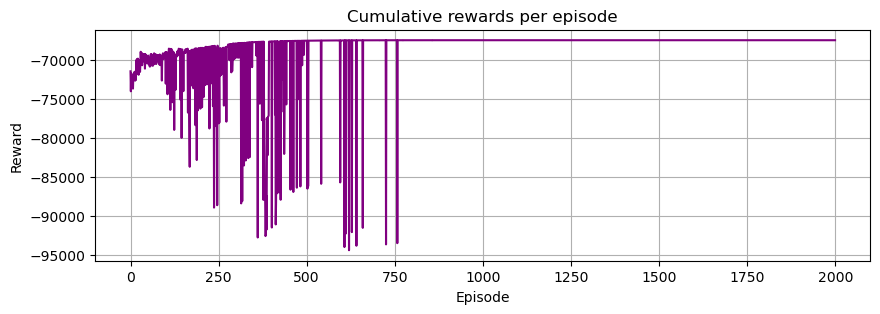

In [8]:
plt.figure(figsize=(10,3))

plt.plot(rewards, color="purple")

plt.title("Cumulative rewards per episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.grid(True)
plt.show()

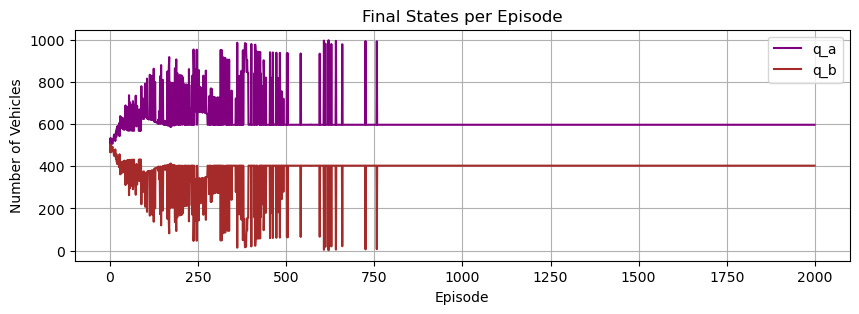

In [9]:
plt.figure(figsize=(10,3))

plt.plot(range(len(final_states)), [x[1] for x in final_states], label="q_a", color="purple")
plt.plot(range(len(final_states)), [x[2] for x in final_states], label="q_b", color="brown")

plt.title("Final States per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Vehicles")

plt.grid(True)
plt.legend()
plt.show()

## Testing

In [10]:
state = env.reset()

total_reward = 0
states = [state]
rewards = list()

for agent in agents:
    
    state = env.startpoint()    
    
    best_action = None
    best_value = float('-inf')
    for action in agent.possible_actions:
        value = agent.Q_values.get((state, action), 0)
        if value > best_value:
            best_value = value
            best_action = action
    
    next_state, reward = env.step(best_action)
    states.append(next_state)
    rewards.append(reward)
    total_reward += reward
    
print("Finished episode at\n State q_a: %d, q_b: %d\n Cumulative reward: %.3f" % (next_state[1], next_state[2], total_reward))

Finished episode at
 State q_a: 597, q_b: 403
 Cumulative reward: -67493.654


***The agents successfully reached to the system optimal solution for this problem!***

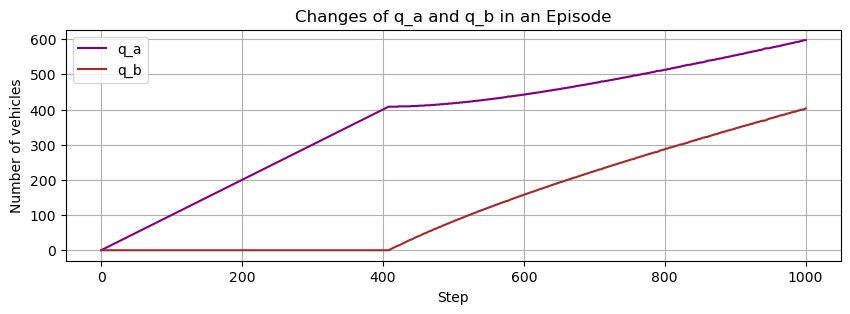

In [11]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [x[1] for x in states], label="q_a", color="purple")
plt.plot(range(len(states)), [x[2] for x in states], label="q_b", color="brown")

plt.title("Changes of q_a and q_b in an Episode")
plt.xlabel("Step")
plt.ylabel("Number of vehicles")

plt.grid(True)
plt.legend()
plt.show()

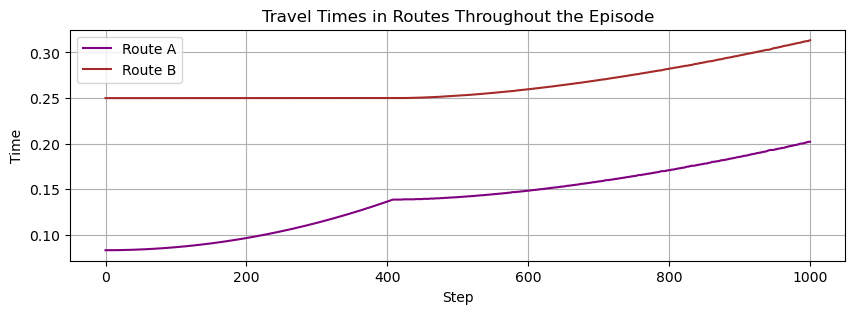

In [12]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [travel_time(x[1], t0_a, Q_a) for x in states], label="Route A", color="purple")
plt.plot(range(len(states)), [travel_time(x[2], t0_b, Q_b) for x in states], label="Route B", color="brown")

plt.title("Travel Times in Routes Throughout the Episode")
plt.xlabel("Step")
plt.ylabel("Time")

plt.grid(True)
plt.legend()
plt.show()

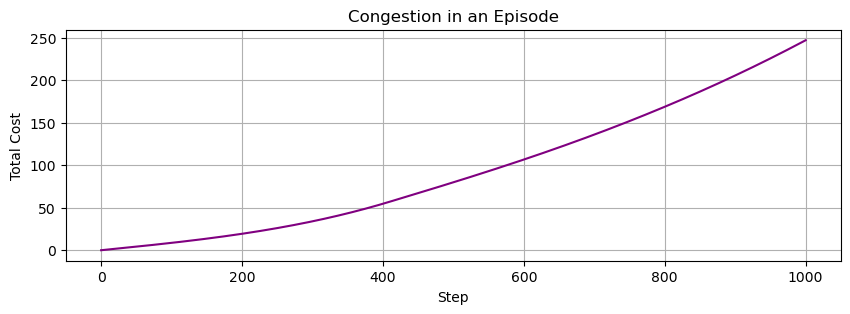

In [13]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [total_cost(x[1], t0_a, Q_a, x[2], t0_b, Q_b, Q) for x in states], color="purple")

plt.title("Congestion in an Episode")
plt.xlabel("Step")
plt.ylabel("Total Cost")

plt.grid(True)
plt.show()

# User Equilibrium (UE)

Previously, we came to the conclusion that the values $q_a = 755$ and $q_b = 245$ are ideal for the User Equilibrium. Let's see if our Multi-Agent RL system can yield the same results.

## Environment

In [14]:
class TrafficEnvironment_UE:
    
    def __init__(self, Q, Q_a, Q_b, t0_a, t0_b):
        self.Q, self.Q_a, self.Q_b = Q, Q_a, Q_b
        self.t0_a, self.t0_b = t0_a, t0_b
        self.reset()

    def reset(self):
        self.q_a, self.q_b = 0, 0
        return ('s', self.q_a, self.q_b)
    
    def startpoint(self):
        return ('s', self.q_a, self.q_b)
        
    def step(self, action):
        if action == 'a':
            self.q_a += 1
        elif action == 'b':
            self.q_b += 1
        else:
            raise ValueError("Action must be 'a' or 'b'")
        
        reward = self.calculate_reward(self.q_a, self.q_b)
        next_state = (action, self.q_a, self.q_b)
        
        return next_state, reward
    
    def calculate_reward(self, q_a, q_b):
        curr_Q = q_a + q_b
        reward = -abs(travel_time(q_a, self.t0_a, self.Q_a) - travel_time(q_b, self.t0_b, self.Q_b))
        reward = reward*(curr_Q/self.Q)
        return reward


## Agent
**We will use the same Q-Learning Agent**

## Training

In [15]:
# Environment & agent
env = TrafficEnvironment_UE(Q, Q_a, Q_b, t0_a, t0_b)
agents = [TrafficAgent() for x in range(Q)]

In [16]:
# Hyperparameters
num_episodes = 2000
decay_rate = 0.99  # Decay rate for epsilon

rewards = list()
final_states = list()

# Training loop
for episode in range(num_episodes):
    state = env.reset()  # Reset the environment for the new episode
    total_reward = 0

    for agent in agents:
        state = env.startpoint()  # New agent starts from s
        
        action = agent.get_action(state)
        next_state, reward = env.step(action)

        # Update Q-value
        agent.update_Q_values(state, action, reward)

        total_reward += reward
        agent.decay_epsilon(decay_rate)
        
    rewards.append(total_reward)
    final_states.append(next_state)

    if ((episode+1) % (num_episodes//10) == 0) or (episode == 0):
        print("------------ EPISODE #%d ------------\n [FINAL REWARD] %.3f [TOTAL REWARD] %.3f [EPSILON] %.6f" \
    % (episode+1, reward, total_reward, agent.epsilon))
        print(" [FINAL STATE] q_a: %d, q_b: %d" % (next_state[1], next_state[2]))

------------ EPISODE #1 ------------
 [FINAL REWARD] -0.179 [TOTAL REWARD] -86.512 [EPSILON] 0.990000
 [FINAL STATE] q_a: 503, q_b: 497
------------ EPISODE #200 ------------
 [FINAL REWARD] -0.120 [TOTAL REWARD] -36.819 [EPSILON] 0.133980
 [FINAL STATE] q_a: 931, q_b: 69
------------ EPISODE #400 ------------
 [FINAL REWARD] -0.114 [TOTAL REWARD] -36.139 [EPSILON] 0.017951
 [FINAL STATE] q_a: 922, q_b: 78
------------ EPISODE #600 ------------
 [FINAL REWARD] -0.008 [TOTAL REWARD] -31.968 [EPSILON] 0.002405
 [FINAL STATE] q_a: 743, q_b: 257
------------ EPISODE #800 ------------
 [FINAL REWARD] -0.000 [TOTAL REWARD] -22.491 [EPSILON] 0.000322
 [FINAL STATE] q_a: 755, q_b: 245
------------ EPISODE #1000 ------------
 [FINAL REWARD] -0.139 [TOTAL REWARD] -36.959 [EPSILON] 0.000043
 [FINAL STATE] q_a: 959, q_b: 41
------------ EPISODE #1200 ------------
 [FINAL REWARD] -0.000 [TOTAL REWARD] -20.939 [EPSILON] 0.000006
 [FINAL STATE] q_a: 755, q_b: 245
------------ EPISODE #1400 ----------

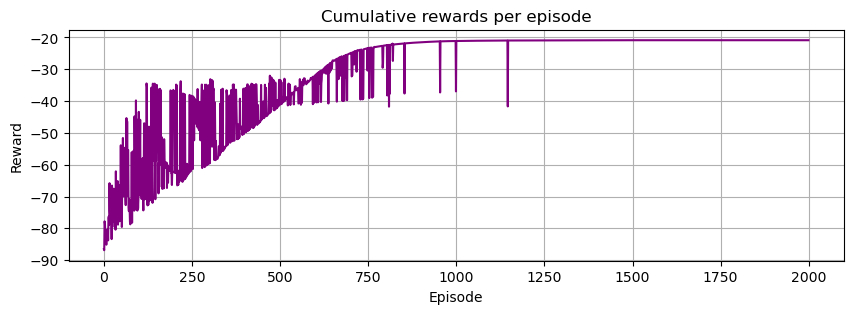

In [17]:
plt.figure(figsize=(10,3))

plt.plot(rewards, color="purple")

plt.title("Cumulative rewards per episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.grid(True)
plt.show()

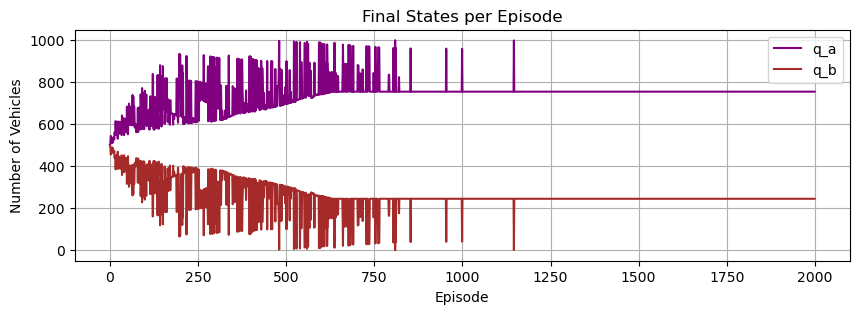

In [18]:
plt.figure(figsize=(10,3))

plt.plot(range(len(final_states)), [x[1] for x in final_states], label="q_a", color="purple")
plt.plot(range(len(final_states)), [x[2] for x in final_states], label="q_b", color="brown")

plt.title("Final States per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Vehicles")

plt.grid(True)
plt.legend()
plt.show()

## Testing

In [19]:
state = env.reset()

total_reward = 0
states = [state]
rewards = list()

for agent in agents:
    
    state = env.startpoint()    
    
    best_action = None
    best_value = float('-inf')
    for action in agent.possible_actions:
        value = agent.Q_values.get((state, action), 0)
        if value > best_value:
            best_value = value
            best_action = action
    
    next_state, reward = env.step(best_action)
    states.append(next_state)
    rewards.append(reward)
    total_reward += reward
    
print("Finished episode at\n State q_a: %d, q_b: %d\n Cumulative reward: %.3f" % (next_state[1], next_state[2], total_reward))

Finished episode at
 State q_a: 755, q_b: 245
 Cumulative reward: -20.870


***The agents successfully found the solution that provides the user equilibrium for this problem!***

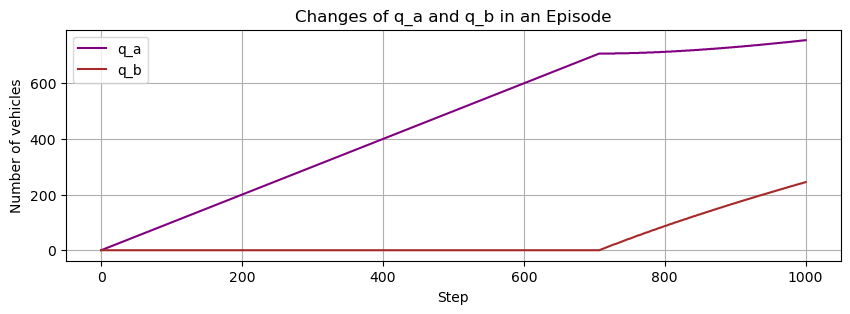

In [20]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [x[1] for x in states], label="q_a", color="purple")
plt.plot(range(len(states)), [x[2] for x in states], label="q_b", color="brown")

plt.title("Changes of q_a and q_b in an Episode")
plt.xlabel("Step")
plt.ylabel("Number of vehicles")

plt.grid(True)
plt.legend()
plt.show()

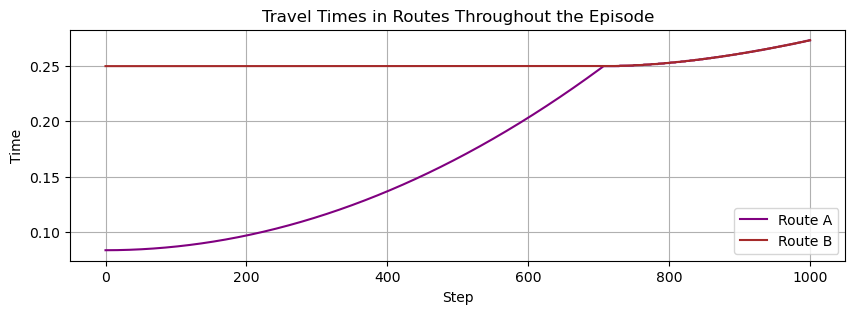

In [21]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [travel_time(x[1], t0_a, Q_a) for x in states], label="Route A", color="purple")
plt.plot(range(len(states)), [travel_time(x[2], t0_b, Q_b) for x in states], label="Route B", color="brown")

plt.title("Travel Times in Routes Throughout the Episode")
plt.xlabel("Step")
plt.ylabel("Time")

plt.grid(True)
plt.legend()
plt.show()

**All drivers chose Route A until the travel times of both routes are equalized. This can be seen as all drivers chose the shortcut route until it became too congested that it does not make a differene anymore. After the travel times equalize, they decided to cooperatively divide between two routes. This is something we did not observe in the centralized approach!**

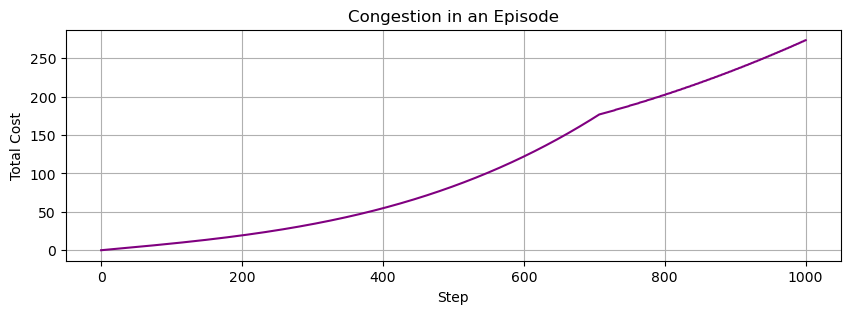

In [22]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [total_cost(x[1], t0_a, Q_a, x[2], t0_b, Q_b, Q) for x in states], color="purple")

plt.title("Congestion in an Episode")
plt.xlabel("Step")
plt.ylabel("Total Cost")

plt.grid(True)
plt.show()

# Conclusion

In this notebook, we dealt with the problem of traffic optimization from multiple perspectives, employing decentralized (multi-agent) model after the centralized one in the previous part of the project. We utilized Q-learning as our go-to reinforcement learning algorithm, demonstrating its adaptability in both settings. 

Through careful design of state, action, and reward spaces, we were able to achieve System Optimum (SO) and User Equilibrium (UE) states. Moreover, the multi-agent model enabled us to examine individual behaviors, see some behaviors that we did not see in the centralized approach.

**In the end, we have created a community that make logical decisions and intelligently cooperate to reach to SO and UE.**